In [29]:
import torch
import numpy as np
from torch import nn, optim
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets,transforms
import cv2
from torch.utils.data import Dataset,DataLoader
from PIL import Image
import os
import torch.nn.functional as F
import random

from torchvision.models import resnet50, vgg16

from skimage import io, transform

from torchvision import transforms, utils
from scipy.ndimage import gaussian_filter
from sklearn.model_selection import train_test_split

!pip install -qU albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

!pip install grad-cam
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image

!pip install pretrainedmodels
import pretrainedmodels

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
EPOCHS = 30
NUM_WORKERS = 4
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

## Network

In [ ]:
import torch
import torch.nn as nn


def double_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True)
    )
    return conv

def addPadding(srcShapeTensor, tensor_whose_shape_isTobechanged):

    if(srcShapeTensor.shape != tensor_whose_shape_isTobechanged.shape):
        target = torch.zeros(srcShapeTensor.shape)
        target[:, :, :tensor_whose_shape_isTobechanged.shape[2],
               :tensor_whose_shape_isTobechanged.shape[3]] = tensor_whose_shape_isTobechanged
        return target
    return tensor_whose_shape_isTobechanged

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(3, 64)
        self.down_conv_2 = double_conv(64, 128)
        self.down_conv_3 = double_conv(128, 256)
        self.down_conv_4 = double_conv(256, 512)
        self.down_conv_5 = double_conv(512, 1024)

        self.up_trans_1 = nn.ConvTranspose2d(
            in_channels=1024,
            out_channels=512,
            kernel_size=2,
            stride=2
        )
        self.up_conv_1 = double_conv(1024, 512)

        self.up_trans_2 = nn.ConvTranspose2d(
            in_channels=512,
            out_channels=256,
            kernel_size=2,
            stride=2
        )
        self.up_conv_2 = double_conv(512, 256)

        self.up_trans_3 = nn.ConvTranspose2d(
            in_channels=256,
            out_channels=128,
            kernel_size=2,
            stride=2
        )
        self.up_conv_3 = double_conv(256, 128)

        self.up_trans_4 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=2,
            stride=2
        )
        self.up_conv_4 = double_conv(128, 64)

        self.out = nn.Conv2d(
            in_channels=64,
            out_channels=1,
            kernel_size=1
        )

    def forward(self, image):
        x1 = self.down_conv_1(image)
        x2 = self.max_pool_2x2(x1)
        x3 = self.down_conv_2(x2)
        x4 = self.max_pool_2x2(x3)
        x5 = self.down_conv_3(x4)
        x6 = self.max_pool_2x2(x5)
        x7 = self.down_conv_4(x6)
        x8 = self.max_pool_2x2(x7)
        x9 = self.down_conv_5(x8)

        # decoder (transposed convolutions increase the size)
        x = self.up_trans_1(x9)
        x = addPadding(x7, x)
        x = self.up_conv_1(torch.cat([x7, x], 1))

        x = self.up_trans_2(x)
        x = addPadding(x5, x)
        x = self.up_conv_2(torch.cat([x5, x], 1))

        x = self.up_trans_3(x)
        x = addPadding(x3, x)
        x = self.up_conv_3(torch.cat([x3, x], 1))

        x = self.up_trans_4(x)
        x = addPadding(x1, x)
        x = self.up_conv_4(torch.cat([x1, x], 1))

        x = self.out(x)

        return x




In [ ]:
image = torch.rand((3, 3, 128, 128)).to(DEVICE)
model = UNet().to(DEVICE)
print(image.shape)
model(image).shape

torch.Size([3, 3, 128, 128])


torch.Size([3, 1, 128, 128])

## Diffrent imeplementation

In [4]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)



class UNet2(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet2, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [5]:
image = torch.rand((3, 3, 128, 128)).to(DEVICE)
model = UNet2(3, 1).to(DEVICE)
print(image.shape)
model(image).shape

torch.Size([3, 3, 128, 128])


torch.Size([3, 1, 128, 128])

## Dataset

In [6]:
RootDir = "/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project"
from google.colab import drive
drive.mount('/content/gdrive')
%cd "/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project"

Mounted at /content/gdrive
/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project


In [87]:
class PetDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None, resizer=None):
        self.label_data = pd.read_csv(csv_file, sep='\s+')
        self.root_dir = root_dir
        self.cam_dir = "/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project/data/cam_score"
        self.mask_dir = "/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project/data/annotations/binary_trimaps"
        ## you can apply custom transformation on the image for data augmentation
        self.transform = transform
        self.resizer = resizer

    def __len__(self):
        return len(self.label_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.label_data.iloc[idx, 0] + ".jpg")
        raw_image = io.imread(img_name)
        image = io.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)

        # cam_path = os.path.join(self.cam_dir, self.label_data.iloc[idx, 0] + ".npy")
        # cam = np.load(cam_path)

        mask_path = os.path.join(self.mask_dir, self.label_data.iloc[idx, 0] + ".png")
        mask = io.imread(mask_path)

        '''
        if self.transform:
            image = self.transform(image)
            # cam = self.resizer(cam)
            mask = self.resizer(mask)[0]
        '''

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations['image']
            mask = augmentations['mask'] / 255.0
            # cam = self.resizer(cam)

        classid = self.label_data.iloc[idx, 1] - 1 # 0:36 class ids
        species = self.label_data.iloc[idx, 2] - 1 # 0:Cat 1:Dog
        sample = {'image': image,
                  'mask': mask,
                  # 'cam': cam,
                  'classid': classid,
                  'species': species,
                  'img_name':img_name
                  }

        return sample 

In [88]:
augNtransform = A.Compose([
    A.Resize(128,128),
    A.Rotate(limit=35,p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    ToTensorV2()  
])

pet_dataset = PetDataset(csv_file="/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project/data/annotations/trainval.txt",
                         root_dir="/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project/data/images",
                         transform = augNtransform,
                         resizer = transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Resize((128, 128)),
                         ]),
                         # transform = transforms.Compose(
                         #             [transforms.ToTensor(),
                         #              transforms.Resize((128, 128))]),
                         )

test_dataset = PetDataset(csv_file="/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project/data/annotations/test.txt",
                         root_dir="/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project/data/images",
                         transform = augNtransform,
                         # transform = transforms.Compose(
                         #              [transforms.ToTensor(),
                         #               transforms.Resize((128, 128))]),
                         resizer = transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Resize((128, 128)),
                         ]))

classid = pet_dataset.label_data.iloc[:, 1]
index = np.array(range(len(classid)))
train_idx, val_idx, y_train, y_test = train_test_split(index, classid, test_size=0.1, stratify=classid)

train_dataset = torch.utils.data.Subset(pet_dataset, train_idx)
val_dataset = torch.utils.data.Subset(pet_dataset, val_idx)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

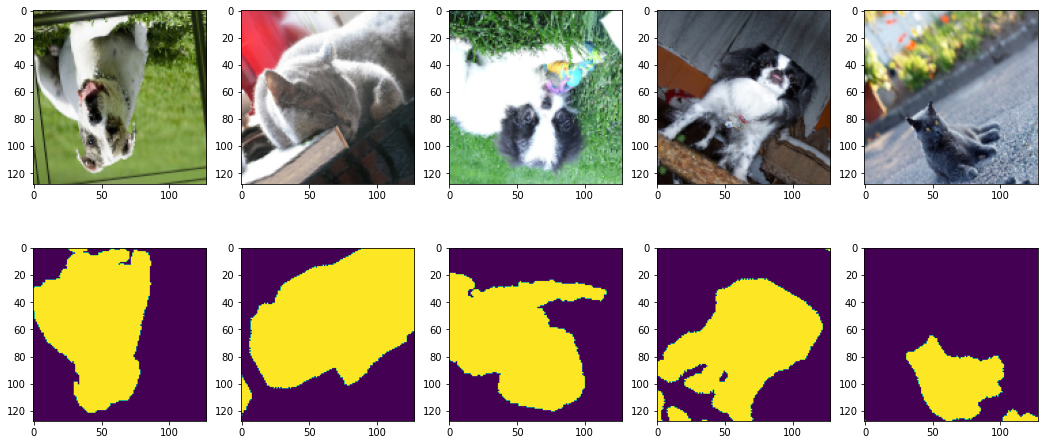

In [74]:
plt.figure(figsize =(18, 8))
posi = 1
for i in random.sample(range(0, 1000), 5):
    img_name = os.path.join(pet_dataset.root_dir, pet_dataset.label_data.iloc[i, 0] + ".jpg")
    image = io.imread(img_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
    mask_path = os.path.join(pet_dataset.mask_dir, pet_dataset.label_data.iloc[i, 0] + ".png")
    mask = io.imread(mask_path)

    transformed = augNtransform(image=image, mask=mask)
    timage = transformed['image']
    tmask = transformed['mask'] / 255.0

    ax = plt.subplot(2, 5, posi)
    ax.imshow(timage.permute(1, 2, 0))
    ax = plt.subplot(2, 5, posi+5)
    ax.imshow(tmask)
    posi += 1

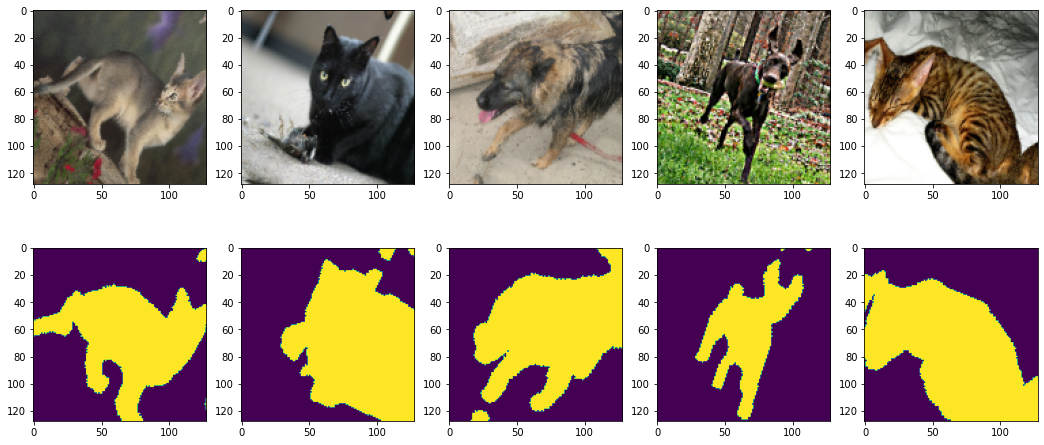

In [75]:
plt.figure(figsize =(18, 8))
posi = 1
for i in random.sample(range(0, 1000), 5):
    data = pet_dataset[i]
    img = data['image']
    ax = plt.subplot(2, 5, posi)
    ax.imshow(img.permute(1, 2, 0))

    mask = data['mask']
    ax = plt.subplot(2, 5, posi + 5)
    ax.imshow(mask)
    posi += 1

## Train

In [76]:
def fit(model, dataloader, optimizer, criterion):
    print('-------------Training---------------')
    model.train()
    train_running_loss = 0.0
    counter=0
    num_batches = int(len(classid) / BATCH_SIZE)
    for i, data in tqdm(enumerate(dataloader),total=num_batches):
        counter+=1
        image,mask = data["image"].to(DEVICE).float(),data["mask"].to(DEVICE)
        optimizer.zero_grad()
        outputs = model(image)
        outputs =outputs.squeeze(1)
        loss = criterion(outputs,mask.float())
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/counter
    return train_loss

def validate(model,dataloader,criterion):
    print("\n--------Validating---------\n")
    model.eval()
    valid_running_loss = 0.0
    counter = 0

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            counter+=1
            image,mask = data["image"].to(DEVICE).float(),data["mask"].to(DEVICE)
            outputs = model(image)
            outputs =outputs.squeeze(1)
            loss = criterion(outputs,mask.float())
            valid_running_loss += loss.item()
    valid_loss = valid_running_loss/counter
    return valid_loss


train_loss = []
val_loss =[]
model = UNet2(3, 1).to(DEVICE)
optimizer = optim.Adam(model.parameters(),lr=1e-5, weight_decay=0.0001)
criterion = nn.BCEWithLogitsLoss()
for epoch in range(EPOCHS):
  print(f"Epoch {epoch+1} of {EPOCHS}")
  train_epoch_loss = fit(model, train_dataloader, optimizer,criterion)
  val_epoch_loss = validate(model, val_dataloader, criterion)
  train_loss.append(train_epoch_loss)
  val_loss.append(val_epoch_loss)
  print(f"Train Loss: {train_epoch_loss:.4f}")
  print(f'Val Loss: {val_epoch_loss:.4f}')

Epoch 1 of 30
-------------Training---------------


 91%|█████████ | 104/114 [01:01<00:05,  1.70it/s]



--------Validating---------

Train Loss: 0.6003
Val Loss: 0.5004
Epoch 2 of 30
-------------Training---------------


 91%|█████████ | 104/114 [00:58<00:05,  1.79it/s]



--------Validating---------

Train Loss: 0.4409
Val Loss: 0.4254
Epoch 3 of 30
-------------Training---------------


 91%|█████████ | 104/114 [00:59<00:05,  1.76it/s]



--------Validating---------

Train Loss: 0.3970
Val Loss: 0.3969
Epoch 4 of 30
-------------Training---------------


 91%|█████████ | 104/114 [00:56<00:05,  1.84it/s]



--------Validating---------

Train Loss: 0.3676
Val Loss: 0.3697
Epoch 5 of 30
-------------Training---------------


 91%|█████████ | 104/114 [00:59<00:05,  1.75it/s]



--------Validating---------

Train Loss: 0.3499
Val Loss: 0.3520
Epoch 6 of 30
-------------Training---------------


 91%|█████████ | 104/114 [00:56<00:05,  1.85it/s]



--------Validating---------

Train Loss: 0.3353
Val Loss: 0.3710
Epoch 7 of 30
-------------Training---------------


 91%|█████████ | 104/114 [00:59<00:05,  1.75it/s]



--------Validating---------

Train Loss: 0.3270
Val Loss: 0.3567
Epoch 8 of 30
-------------Training---------------


 91%|█████████ | 104/114 [00:56<00:05,  1.85it/s]



--------Validating---------

Train Loss: 0.3146
Val Loss: 0.3418
Epoch 9 of 30
-------------Training---------------


 91%|█████████ | 104/114 [00:59<00:05,  1.75it/s]



--------Validating---------

Train Loss: 0.3091
Val Loss: 0.3318
Epoch 10 of 30
-------------Training---------------


 91%|█████████ | 104/114 [00:57<00:05,  1.80it/s]



--------Validating---------

Train Loss: 0.3071
Val Loss: 0.3185
Epoch 11 of 30
-------------Training---------------


 91%|█████████ | 104/114 [00:59<00:05,  1.73it/s]



--------Validating---------

Train Loss: 0.3001
Val Loss: 0.3386
Epoch 12 of 30
-------------Training---------------


 91%|█████████ | 104/114 [00:56<00:05,  1.84it/s]



--------Validating---------

Train Loss: 0.2920
Val Loss: 0.3206
Epoch 13 of 30
-------------Training---------------


 91%|█████████ | 104/114 [00:59<00:05,  1.76it/s]



--------Validating---------

Train Loss: 0.2872
Val Loss: 0.3384
Epoch 14 of 30
-------------Training---------------


 91%|█████████ | 104/114 [00:57<00:05,  1.81it/s]



--------Validating---------

Train Loss: 0.2831
Val Loss: 0.3162
Epoch 15 of 30
-------------Training---------------


 91%|█████████ | 104/114 [01:00<00:05,  1.72it/s]



--------Validating---------

Train Loss: 0.2786
Val Loss: 0.3021
Epoch 16 of 30
-------------Training---------------


 91%|█████████ | 104/114 [00:56<00:05,  1.84it/s]



--------Validating---------

Train Loss: 0.2712
Val Loss: 0.3129
Epoch 17 of 30
-------------Training---------------


 91%|█████████ | 104/114 [00:56<00:05,  1.85it/s]



--------Validating---------

Train Loss: 0.2700
Val Loss: 0.3013
Epoch 18 of 30
-------------Training---------------


 91%|█████████ | 104/114 [00:59<00:05,  1.75it/s]



--------Validating---------

Train Loss: 0.2630
Val Loss: 0.2908
Epoch 19 of 30
-------------Training---------------


 91%|█████████ | 104/114 [00:56<00:05,  1.84it/s]



--------Validating---------

Train Loss: 0.2613
Val Loss: 0.2992
Epoch 20 of 30
-------------Training---------------


 91%|█████████ | 104/114 [00:59<00:05,  1.76it/s]



--------Validating---------

Train Loss: 0.2593
Val Loss: 0.2882
Epoch 21 of 30
-------------Training---------------


 91%|█████████ | 104/114 [00:56<00:05,  1.83it/s]



--------Validating---------

Train Loss: 0.2564
Val Loss: 0.2922
Epoch 22 of 30
-------------Training---------------


 91%|█████████ | 104/114 [00:59<00:05,  1.76it/s]



--------Validating---------

Train Loss: 0.2496
Val Loss: 0.2934
Epoch 23 of 30
-------------Training---------------


 91%|█████████ | 104/114 [00:56<00:05,  1.85it/s]



--------Validating---------

Train Loss: 0.2457
Val Loss: 0.2973
Epoch 24 of 30
-------------Training---------------


 91%|█████████ | 104/114 [00:59<00:05,  1.76it/s]



--------Validating---------

Train Loss: 0.2419
Val Loss: 0.2719
Epoch 25 of 30
-------------Training---------------


 91%|█████████ | 104/114 [00:56<00:05,  1.85it/s]



--------Validating---------

Train Loss: 0.2402
Val Loss: 0.2800
Epoch 26 of 30
-------------Training---------------


 91%|█████████ | 104/114 [00:59<00:05,  1.75it/s]



--------Validating---------

Train Loss: 0.2353
Val Loss: 0.2785
Epoch 27 of 30
-------------Training---------------


 91%|█████████ | 104/114 [00:56<00:05,  1.85it/s]



--------Validating---------

Train Loss: 0.2358
Val Loss: 0.2773
Epoch 28 of 30
-------------Training---------------


 91%|█████████ | 104/114 [00:58<00:05,  1.76it/s]



--------Validating---------

Train Loss: 0.2299
Val Loss: 0.2952
Epoch 29 of 30
-------------Training---------------


 91%|█████████ | 104/114 [00:56<00:05,  1.85it/s]



--------Validating---------

Train Loss: 0.2321
Val Loss: 0.2657
Epoch 30 of 30
-------------Training---------------


 91%|█████████ | 104/114 [00:59<00:05,  1.76it/s]



--------Validating---------

Train Loss: 0.2206
Val Loss: 0.2738


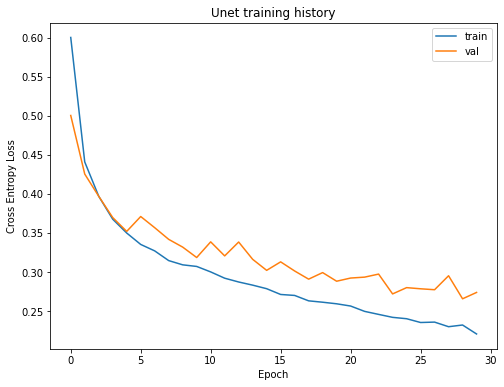

In [81]:
plt.figure(figsize =(8, 6))
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="val")
plt.title("Unet training history")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
_ = plt.legend()

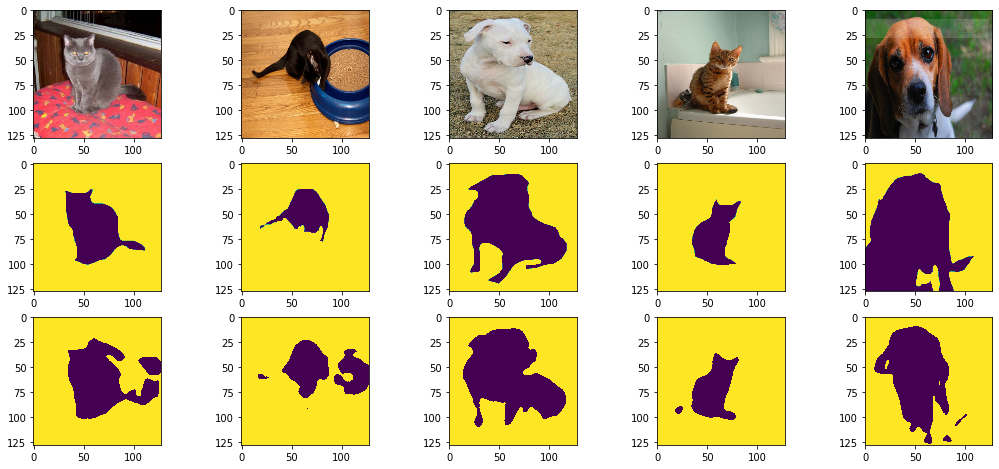

In [41]:
plt.figure(figsize =(18, 8))
posi = 1
for i in random.sample(range(0, 1000), 5):
    data = test_dataset[i]
    image = data['image']
    mask = data['mask']

    ax = plt.subplot(3, 5, posi)
    ax.imshow(image.permute(1, 2, 0))
    ax = plt.subplot(3, 5, posi+5)
    ax.imshow(mask)

    ax = plt.subplot(3, 5, posi+10)
    img = data["image"].unsqueeze(0).to(device="cuda")
    output = model(img)
    output = torch.squeeze(output)
    output[output>0.0] = 1.0
    output[output<=0.0]=0
    ax.imshow(output.cpu().detach().numpy())
    posi += 1

In [80]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project/UnetV1.pt')

In [89]:
accuracy = 0.0
totaliou = 0.0
counter = 0
test_model = UNet2(3, 1).to(DEVICE)
test_model.load_state_dict(torch.load('/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project/model_Unet.pt'))

with torch.no_grad():
  for i, data in enumerate(test_dataloader):
      counter+=1
      image,mask = data["image"].to(DEVICE).float(),data["mask"].to(DEVICE)
      outputs = test_model(image)
      outputs =outputs.squeeze(1)
      output[output>0.0] = 1.0
      output[output<=0.0] = 0.0

      correct = torch.sum(output == mask)
      acc = correct / (BATCH_SIZE * 128 * 128)
      accuracy = accuracy + ((1 / (counter + 1)) * (acc - accuracy))

      tp = torch.sum(output * mask)
      iou = tp / (output.sum() + mask.sum() - tp)
      totaliou = totaliou + ((1 / (counter + 1)) * (iou - totaliou))

print("Acc: ", accuracy)
print("IOU: ", iou)

Acc:  tensor(0.7051, device='cuda:0')
IOU:  tensor(2.8481, device='cuda:0')


## Format mask file

In [78]:
label_data = pd.read_csv("/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project/data/annotations/test.txt", sep='\s+')
for i in range(len(label_data)):
  raw_path = f"/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project/data/annotations/trimaps/{label_data.iloc[i, 0]}.png"
  raw_mask = io.imread(raw_path)
  new_mask = (raw_mask != 2) * 1
  save_path = f"/content/gdrive/MyDrive/columbia/cs4995 Deep Learning/project/data/annotations/trimaps_2/{label_data.iloc[i, 0]}.png"
  im = Image.fromarray((new_mask * 255).astype(np.uint8))
  im.save(save_path)
  print(f"{i}: {label_data.iloc[i, 0]} saved")

0: Abyssinian_202 saved
1: Abyssinian_204 saved
2: Abyssinian_205 saved
3: Abyssinian_206 saved
4: Abyssinian_207 saved
5: Abyssinian_20 saved
6: Abyssinian_210 saved
7: Abyssinian_212 saved
8: Abyssinian_213 saved
9: Abyssinian_215 saved
10: Abyssinian_216 saved
11: Abyssinian_217 saved
12: Abyssinian_219 saved
13: Abyssinian_21 saved
14: Abyssinian_220 saved
15: Abyssinian_221 saved
16: Abyssinian_223 saved
17: Abyssinian_224 saved
18: Abyssinian_225 saved
19: Abyssinian_226 saved
20: Abyssinian_228 saved
21: Abyssinian_22 saved
22: Abyssinian_230 saved
23: Abyssinian_232 saved
24: Abyssinian_24 saved
25: Abyssinian_25 saved
26: Abyssinian_26 saved
27: Abyssinian_27 saved
28: Abyssinian_29 saved
29: Abyssinian_2 saved
30: Abyssinian_30 saved
31: Abyssinian_31 saved
32: Abyssinian_32 saved
33: Abyssinian_33 saved
34: Abyssinian_36 saved
35: Abyssinian_37 saved
36: Abyssinian_3 saved
37: Abyssinian_40 saved
38: Abyssinian_43 saved
39: Abyssinian_44 saved
40: Abyssinian_45 saved
41: Aby